In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import random

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
### Добавление шума

# Обнуление части пикcелей
def add_null_noise(data):    
    null_ratio = 0.4
    mp = [torch.distributions.bernoulli.Bernoulli(torch.tensor([1-null_ratio])).sample().detach().numpy() for _ in range(50*28*28)]
    mpr = torch.Tensor(mp).view(-1, 1, 28, 28) 
    return data * mpr

# Белый шум
def add_norm_noise(data):
    noise = torch.randn(50, 28*28).view(-1, 1, 28, 28).clamp(-1, 1)
    return data + noise

# Обнуление левой стороны
def remove_left_part(data):
    mpz = torch.zeros((28, 14))
    mpo = torch.ones((28, 14))
    mpr = torch.cat((mpz, mpo), 1).view(-1, 1, 28, 28) 
    return data * mpr

def some_noise(data):
    rand = random.randint(1,3)
    noise_map = {
        1 : add_null_noise,
        2 : add_norm_noise,
        3 : remove_left_part
    }
    return noise_map[rand](data)

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            data_noised = some_noise(data)
            output = model(data_noised)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
            #to_plot = data_noised.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            #plot_mnist(to_plot, (5, 10))
            
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [29]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64: 0.213104
Train Epoch: 1 [10000/50000 (20%)]	Losses 64: 0.216240
Train Epoch: 1 [20000/50000 (40%)]	Losses 64: 0.214142
Train Epoch: 1 [30000/50000 (60%)]	Losses 64: 0.200429
Train Epoch: 1 [40000/50000 (80%)]	Losses 64: 0.192246
Train Epoch: 1 [50000/50000 (100%)]	Losses 64: 0.171291
Test set:
64: loss: 0.1813	pho_loss: 0.0040

Train Epoch: 2 [0/50000 (0%)]	Losses 64: 0.176393
Train Epoch: 2 [10000/50000 (20%)]	Losses 64: 0.177170
Train Epoch: 2 [20000/50000 (40%)]	Losses 64: 0.173091
Train Epoch: 2 [30000/50000 (60%)]	Losses 64: 0.176858
Train Epoch: 2 [40000/50000 (80%)]	Losses 64: 0.182600
Train Epoch: 2 [50000/50000 (100%)]	Losses 64: 0.154498
Test set:
64: loss: 0.1562	pho_loss: 0.0040

Train Epoch: 3 [0/50000 (0%)]	Losses 64: 0.161631
Train Epoch: 3 [10000/50000 (20%)]	Losses 64: 0.153781
Train Epoch: 3 [20000/50000 (40%)]	Losses 64: 0.150834
Train Epoch: 3 [30000/50000 (60%)]	Losses 64: 0.161058
Train Epoch: 3 [40000/50000 (80%)]	Losses 6

In [30]:
torch.save(models['64'], './model_64_dn')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [7]:
model = torch.load('./model_64_dn')

In [12]:
data, _ = next(iter(test_loader))
data_noised = add_null_noise(data)
output = model(data_noised)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

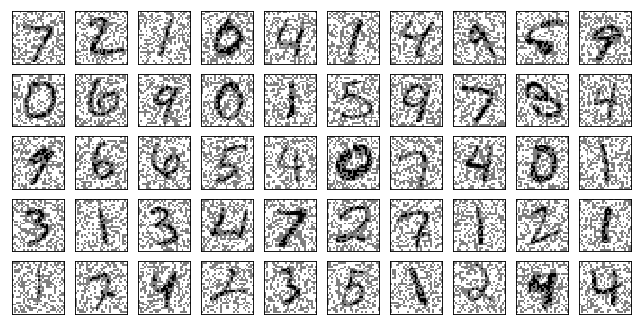

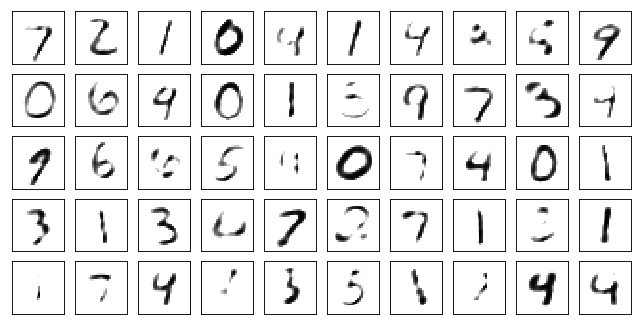

In [13]:
plot_mnist(data_noised.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))

In [14]:
data, _ = next(iter(test_loader))
data_noised = add_norm_noise(data)
output = model(data_noised)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

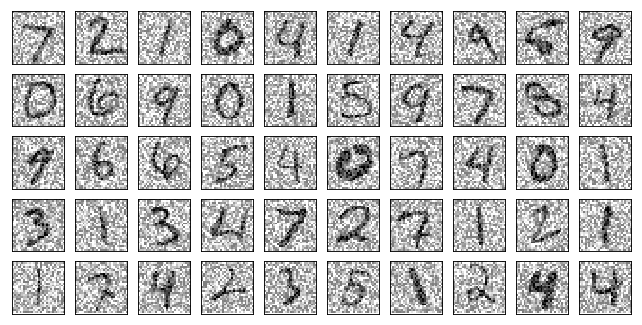

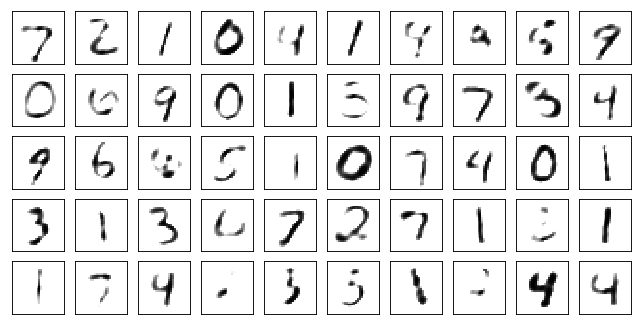

In [15]:
plot_mnist(data_noised.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))

In [16]:
data, _ = next(iter(test_loader))
data_noised = remove_left_part(data)
output = model(data_noised)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

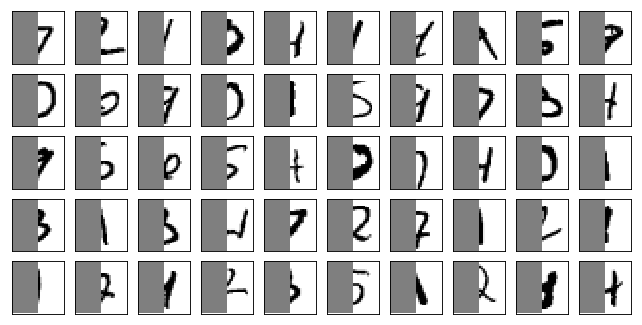

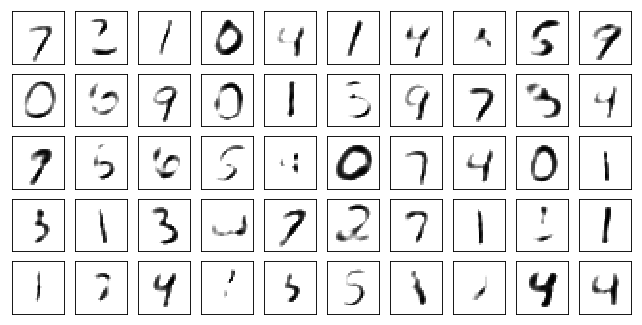

In [17]:
plot_mnist(data_noised.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))